# Test-Time Adaptation For Image Classification

**Authors**: Leonardo Giammarella, Enrico Zanetti


This project focuses on implementing a test-time adaptation technique for image classification based on the MEMO (marginal entropy minimization with one test point) approach. The primary goal is to improve the robustness and accuracy of pre-trained convolutional neural networks (CNNs) when deployed in environments with data distributions that differ from the training set. This is achieved by leveraging test-time augmentations and entropy minimization to adapt the model to new data distributions on-the-fly.

### Introduction

Deep learning models, particularly CNNs, have achieved state-of-the-art performance in image classification tasks. However, these models often struggle with generalization when deployed in real-world scenarios where the test data distribution differs significantly from the training data. This phenomenon, known as distribution shift, can degrade the model's performance.

The MEMO approach [1] addresses this issue by employing test-time adaptations to minimize the entropy of the averaged model's predictions. This method ensures that the model remains confident in its predictions even when faced with unseen or distorted data. The key idea is to adapt the model parameters during inference by using a batch of the test image and its augmentations, thereby reducing the entropy of the marginal distribution over the class labels.

### Architecture Overview

The solution is built upon a pre-trained ResNet50 model, with modifications to support test-time adaptation using the MEMO approach.

**Components**

1. Pre-trained CNN: ResNet50 is used as the base model for its proven performance in image classification tasks.
2. Test-time Adaptations: A batch of test images, including the original test image and some random augmentations, is used to adapt the model during inference.
3. Entropy Minimization: The entropy of the marginal distribution is computed and minimized through backpropagation during test-time.
4. Loss Functions: The primary loss function used in this approach is the entropy of the marginal distribution. Minimizing this entropy ensures that the model remains confident in its predictions even under distribution shift.

#### Pipeline

The pipeline involves the following steps:

1. Load Pre-trained Model: Import ResNet50 with pre-trained weights.
2. Dataset Preparation: Load the test dataset and apply augmentations to generate a batch of images for each test sample.
3. Forward Pass: Perform a forward pass to compute the initial predictions.
4. Entropy Calculation: Compute the entropy of the marginal distribution from the model's outputs.
5. Optimization Step: Perform one or more backpropagation steps to minimize the entropy for each test image.
6. Final Predictions: Compute the final predictions after adaptation (averaged over the batch of image + augmentations) and evaluate the model's performance.

To enhance model's performance we used two main approaches:
- Adaptive Batch Normalization (as implemented in [1]).
- A confidence selection technique inspired by [2], that is used to reduce noise from random augmentations. After the model outputs are computed for a test sample, which includes the initial image and several random augmentations, the entropy of the distribution for each image in the batch is calculated. The images with the k lowest entropy values (i.e., the augmentations with the most confident outputs) are then retained for computing the predicted class for that test sample.

![architecture_diagram](architecture_diagram.png)

### Instructions to run the code

To execute the following code, you have to upload the file *imagenet_class_index.json*.

### Import libraries

In [21]:
# Deep Learning and Computer Vision Libraries
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import AugMix

# File and Directory Handling Libraries
import os
from pathlib import Path
import boto3
from io import BytesIO
from PIL import Image, UnidentifiedImageError

# Random Number Generation and Data Manipulation Libraries
import random
import numpy as np
import json

# Data Visualization and Plotting Libraries
import matplotlib.pyplot as plt

# Time and Timing Libraries
import time

### Some utility functions

Several utility functions are used in the test-time adaptation pipeline for image classification. These functions handle entropy of average distribution calculation, selection of top-k confident outputs, checkpointing, and formatted result printing.

In [22]:
def resize_keep_ar(image, target_size=224):
    """
    The function resizes an input image such that the larger dimension (width or
    height) is set to the target size (224 pixels by default). The other
    dimension is scaled proportionally to preserve the original aspect ratio.
    """
    # Original dimensions
    original_width, original_height = image.size
    # Calculate the new dimensions
    if original_width > original_height:
        new_width = target_size
        new_height = int((original_height / original_width) * target_size)
    else:
        new_height = target_size
        new_width = int((original_width / original_height) * target_size)
    # Resize the image
    resized_img = image.resize((new_width, new_height))

    return resized_img


def marginal_entropy(outputs):
    """
    This function takes the raw outputs of a model (a tensor of dimensions
    [batch_size, num_output_classes]) and computes the entropy of the
    marginal distribution.
    """
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)


def select_top_k(outputs: torch.Tensor, k: int) -> torch.Tensor:
    """
    Selects the top k most confident distributions (i.e., distributions with
    the k lowest entropy) from a tensor of raw outputs.
    outputs is a tensor of outputs of shape [N+1, num_classes].
    top_k_distributions is a tensor of shape [k, num_classes].
    """
    # Convert raw outputs to probabilities
    probabilities = torch.softmax(outputs, dim=1)
    # Calculate entropy for each distribution
    entropy_values = -torch.sum(probabilities * torch.log(probabilities), dim=1)
    # Sort indices based on entropy values
    sorted_indices = torch.argsort(entropy_values)
    # Select the top k indices with lowest entropy
    top_k_indices = sorted_indices[:k]
    # Select the top k distributions
    top_k_distributions = outputs[top_k_indices]

    return top_k_distributions


# Test-time checkpoint mechanism
def save_test_checkpoint(checkpoint_path, idx_last_processed_image, n_valid_samples,
                         n_correct_bf, n_correct_augm_bf, n_correct_af):
    """
    Save information about last image processed, number of samples correctly
    opened, and the number of correct predictions in three cases. Useless to
    save information about the model and the optimizer since we are doing only
    testing (and we reinitialize the model before each test sample).
    """
    checkpoint = {
        'idx_last_processed_image': idx_last_processed_image,
        'n_valid_samples': n_valid_samples,
        'n_correct_bf': n_correct_bf,
        'n_correct_augm_bf': n_correct_augm_bf,
        'n_correct_af': n_correct_af
    }
    torch.save(checkpoint, checkpoint_path)


def load_test_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    idx_last_processed_image = checkpoint['idx_last_processed_image']
    n_valid_samples = checkpoint['n_valid_samples']
    n_correct_bf = checkpoint['n_correct_bf']
    n_correct_augm_bf = checkpoint['n_correct_augm_bf']
    n_correct_af = checkpoint['n_correct_af']
    return idx_last_processed_image, n_valid_samples, n_correct_bf, n_correct_augm_bf, n_correct_af


def vprint(message, verbose=True):
    """
    Utility function to print information during test loop if requested
    """
    if verbose:
        print(message)


def print_formatted_result(exp_name: str, n_correct_bf: int, n_correct_augm_bf: int, n_correct_af: int, n_valid_samples: int, dataset: str):
    """
    Utility function to print the results of an experiment in a pretty way.
    """
    print(f'Results of experiment {exp_name} on {dataset}:')
    print(f'Top 1 accuracy using single test image: {n_correct_bf/n_valid_samples *100:.3f}%')
    print(f'Top 1 accuracy using test image + augmentations: {n_correct_augm_bf/n_valid_samples*100:.3f}%')
    print(f'Top 1 accuracy with test-time adaptation: {n_correct_af/n_valid_samples*100:.3f}%')


def results(experiment_name: str, dataset: str):
    """
    Print results of an experiment.

    Parameters:
    experiment_name (str): Name of the experiment.
    dataset (str): Name of the dataset (e.g., 'Imagenet-A' or 'Imagenet-v2').
    """
    results_path = os.path.join("checkpoints", experiment_name + '.pth')
    idx_last_processed_image, n_valid_samples, n_correct_bf, n_correct_augm_bf, n_correct_af = load_test_checkpoint(results_path)
    print('Index of last processed image: ', idx_last_processed_image)
    print_formatted_result(experiment_name, n_correct_augm_bf, n_correct_af, n_valid_samples, dataset)

### Dataset class

**S3ImageFolder**

The S3ImageFolder class is a custom dataset class that extends torch.utils.data.Dataset. In particular:
1. it loads images from an S3 bucket;
2. it resizes the image to 244 (mantaining the original aspect ratio) if the image is too big (i.e., if $min(H,W)>600$);
3. a specified number *num_augmentations* of random augmentations (chosen from a list of possible augmentations) is applied to each image;
4. Optionally, additional transformations required by the base model used are applied to the test image and its augmentations. In particular, we applied to images and augmentations the default transformations required by ResNet50.

Each data point returned is a batch containing the original image and its augmented versions.

The choice in point 2 of resizing only too big images is suggested by the following empirical observations: if no resize is not done prior to the creation of augmentations and subsequent transformations, the kernel dies during the execution whenever very big images are loaded. On the other hand, by resizing all the images, the performance of the base model drops quite significantly. Therefore, resizing only images whose dimensions exceeded a fixed threshold (600) seemed to be a quite reasonable trade-off. 

In [23]:
class S3ImageFolder(Dataset):
    """
    This class takes a directory where images are stored, a list of (possible) augmentations,
    the number of augmentations to apply, and an optional list of transformations.
    It loads images from the specified directory, applies a fixed number of random
    augmentations to each image, and applies the transformation pipeline, if provided.
    """

    def __init__(self, root_dir, augmentations, num_augmentations=5, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"  # Ireland
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.root_dir = root_dir
        self.augmentations = augmentations
        self.num_augmentations = num_augmentations
        self.transform = transform

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root_dir)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root_dir,
                ContinuationToken=response["NextContinuationToken"]
            )
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)

            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):

        label, key = self.instances[idx]

        # Download image as bytes array
        img_bytes = BytesIO()
        self.s3_client.download_fileobj(Bucket=self.s3_bucket, Key=key, Fileobj=img_bytes)

        # Check if image is opened correctly
        try:
            img = Image.open(img_bytes).convert('RGB')
        except UnidentifiedImageError:
            # If it cannot be opened
            return None, None  # This image will be skipped later

        # Resize image if it is too big
        width, height = img.size
        if min(width, height) > 600:
            img = resize_keep_ar(img)  # Resize to 224, keeping aspect ratio
        img = T.functional.to_tensor(img)  # Turn to tensor

        # Create num_augmentations augmentations
        augmented_images = [img]
        random_augm = random.sample(population=self.augmentations, k=self.num_augmentations)
        for augmentation in random_augm:
            augmented_image = augmentation(img)
            augmented_images.append(augmented_image)

        # Apply transformations
        if self.transform:
            augmented_images = [self.transform(img) for img in augmented_images]

        # Create a batch including the original image and its augmentations.
        # Eeach test sample is a batch containing 1 + num_augmentations images, so
        # it is a tensor with dimensions [num_augmentations + 1, 3, H, W].
        test_sample = torch.stack(augmented_images, dim=0)

        return test_sample, label

In [24]:
# Download README.txt from ImagenetA folder to then create the mask for the 200 Imagenet-A classes

# Define bucket name and object key
bucket_name = 'deeplearning2024-datasets'
object_key = 'imagenet-a/README.txt'
# Define local file path to save the downloaded file
local_file_path = 'README.txt'

# Initialize S3 client
s3 = boto3.client('s3')
# Download README.txt file from S3 bucket
s3.download_file(bucket_name, object_key, local_file_path)

# 1) Extract list of 200 classes of Imagenet-A from README.txt file

# Imagenet-A's README.txt file
file_path = 'README.txt'

# List to store the IDs of the 200 Imagenet-A classes
ids_200 = []
with open(file_path, 'r') as file:
    for line in file:
        # Check if the line starts with 'n' followed by digits and contains a space
        if line.startswith('n') and ' ' in line:
            # Extract the WordNet ID by splitting the line at the first space
            wnid = line.split(' ')[0]
            ids_200.append(wnid)


# 2) Extract in a list the 1000 ids of the imagenet-1k classes

# Load the JSON file "imagenet_class_index.json" containing Imagenet classes and IDs
with open('imagenet_class_index.json', 'r') as f:
    data = json.load(f)

# Extract the codes from the dictionary values
ids_1000 = [value[0] for value in data.values()]


# Create a boolean mask based on whether the class ID at each index in the
# list of 1000 IDs is present in the list of 200 IDs corresponding to the
# classes of Imagenet-A. The resulting mask list will have True values at those
# indices where the class ID is in the Imagenet-A classes, and False otherwise.
mask = [ids_1000[i] in ids_200 for i in range(1000)]

### Augmentations

The following code defines a list of 22 possible augmentations that can be applied to images. These augmentations include both deterministic and random transformations to increase the variability and robustness of dataset.

In [25]:
# Define the list of possible augmentations (22).

possible_augmentations = [

    # Deterministic augmentations
    T.RandomHorizontalFlip(p=1),
    T.RandomVerticalFlip(p=1),
    T.RandomInvert(p=1),
    T.ElasticTransform(alpha=50.),
    T.CenterCrop(size=250),
    T.Grayscale(num_output_channels=3),

    # Random augmentations
    T.Compose([T.RandomRotation(degrees=(0, 30)), T.CenterCrop(size=350)]),
    T.Compose([T.RandomRotation(degrees=(30, 60)), T.CenterCrop(size=350)]),
    T.Compose([T.RandomRotation(degrees=(60, 90)), T.CenterCrop(size=350)]),
    T.Compose([T.RandomRotation(degrees=(90, 120)), T.CenterCrop(size=350)]),
    T.Compose([T.RandomRotation(degrees=(120, 150)), T.CenterCrop(size=350)]),
    T.Compose([T.RandomRotation(degrees=(150, 180)), T.CenterCrop(size=350)]),
    T.RandomAffine(degrees=(-30, 30), translate=(0.2, 0.2), scale=(0.8, 1.2)),
    T.RandomAffine(degrees=(-30, 30), translate=(0.3, 0.3), scale=(0.8, 1.2)),
    T.RandomAffine(degrees=(-30, 30), translate=(0.2, 0.3), scale=(0.2, 2)),
    T.RandomAffine(degrees=(-30, 30), translate=(0.2, 0.2), scale=(0.5, 1.8)),
    T.Compose([T.RandomPerspective(distortion_scale=0.4, p=1), T.CenterCrop(size=350)]),
    T.ColorJitter(brightness=.5, hue=.3),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.15, 5.5)),
    T.RandomCrop(size=270, pad_if_needed=True, fill=0, padding_mode='constant'),
    T.RandomCrop(size=300, pad_if_needed=True, fill=0, padding_mode='constant'),
    T.RandomCrop(size=350, pad_if_needed=True, fill=0, padding_mode='constant')
]

### Example of usage of dataset

In [26]:
# Example of usage of dataset

# Define the directory containing the dataset
root_dir = 'imagenet-a/'

# Transformations to be applied
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Instantiate the dataset
dataset_A = S3ImageFolder(root_dir,
                          augmentations=possible_augmentations,
                          num_augmentations=15,
                          transform=transform)

In [27]:
# Example of label
_, lab = dataset_A[2931]
print(lab)

n02123394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

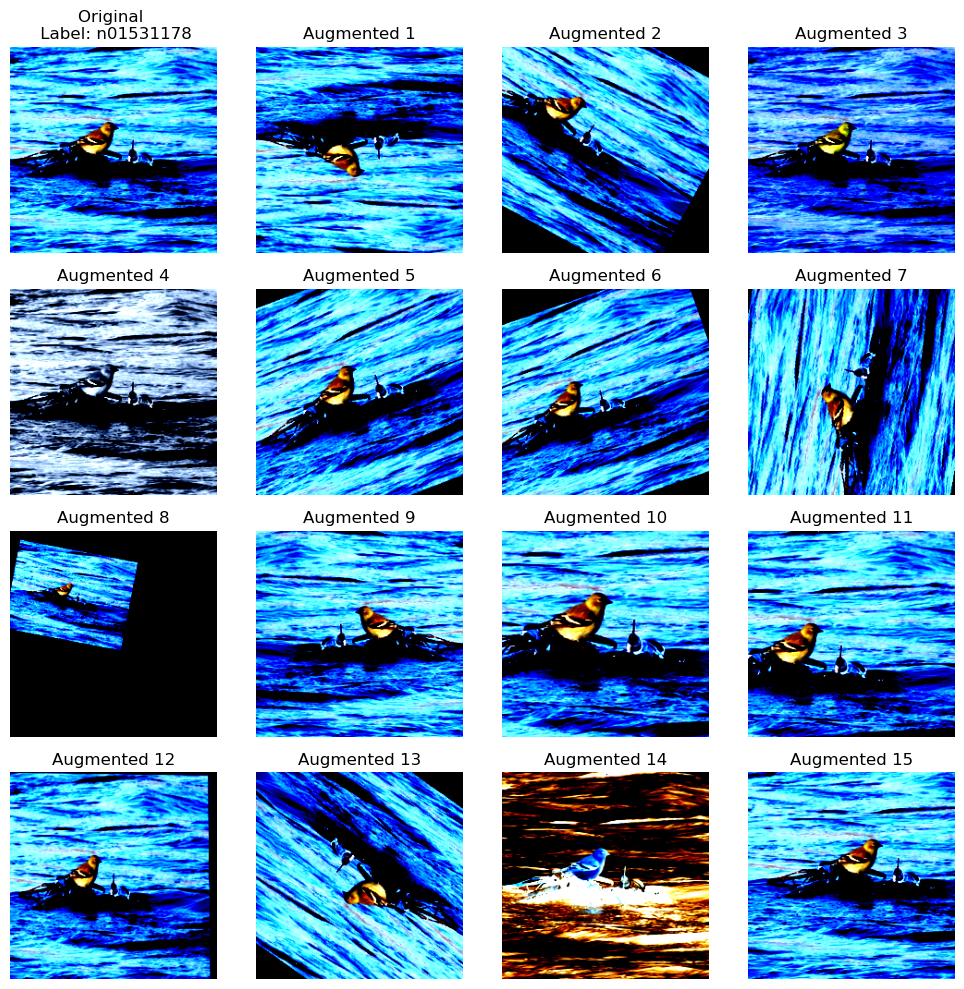

In [28]:
# Show one example
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
i = 140  # Index of sample to show
sample, label = dataset_A[i]

# Display each image in the sample
for j, img in enumerate(sample):
    ax = axes[j // 4, j % 4]
    # Normalize the pixel values to be within [0, 1]
    img = img.permute(1, 2, 0)
    img = img.numpy()  # Convert PyTorch tensor to NumPy array
    ax.imshow(img)
    ax.axis('off')
    # Caption the images
    if j == 0:
        ax.set_title(f'Original \n Label: {label}')
    else:
        ax.set_title(f'Augmented {j}')

plt.tight_layout()
plt.show()

### Augmix dataset class

The AugMixDataset class is a custom dataset class that extends torch.utils.data.Dataset. It is very similar to the previously defined dataset class:
 - it loads images from an S3 bucket;
 - for each test image, a specified number of augmentations is created. Each augmentation is made up of a random horizontal flip (with a probability of 40%), followed by an AugMix augmentation with the severity parameter set to 10 (its maximum value).
 - As in the previous case, additional transformations are applied, if requested.

Each data point returned is a batch containing the original image and its augmented versions.

In [29]:
class AugMixDataset(Dataset):
    """
    This class takes a root directory where images are stored, the number N of
    augmentations to apply and an optional list of transformations. It loads 
    images from the specified directory, applies N AugMix augmentations
    to each image, and applies the transformation pipeline if provided.
    Each datapoint returned is a batch of 1 + N images.
    """

    def __init__(self, root_dir, num_augmentations, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"  # Ireland
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.root_dir = root_dir
        self.num_augmentations = num_augmentations
        self.transform = transform

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root_dir)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root_dir,
                ContinuationToken=response["NextContinuationToken"]
            )
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)

            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):

        label, key = self.instances[idx]

        # Download image as bytes array
        img_bytes = BytesIO()
        self.s3_client.download_fileobj(Bucket=self.s3_bucket, Key=key, Fileobj=img_bytes)

        # Check if image is opened correctly
        try:
            img = Image.open(img_bytes).convert('RGB')
        except UnidentifiedImageError:
            # If image cannot be opened, it will be skipped later
            return None, None

        # Resize image if it is too big
        width, height = img.size
        if min(width, height) > 600:
            img = resize_keep_ar(img)  # Resize to 224, keeping aspect ratio

        # Create num_augmentations augmentations
        augmented_images = [img]
        for _ in range(self.num_augmentations):
            aug_transform = AugMix(severity=10)
            flip = T.RandomHorizontalFlip(p=0.4)
            img = flip(img)  # apply a random horizontal flip before augmenting it
            augmented_img = aug_transform(img)  # apply Augmix augmentation
            augmented_images.append(augmented_img)

        # Apply transformations
        if self.transform:
            augmented_images = [self.transform(img) for img in augmented_images]

        # Create a batch including the original image and its augmentations.
        # Eeach test sample is a batch containing 1 + num_augmentations images, so
        # it is a tensor with dimensions [num_augmentations + 1, 3, H, W].
        test_sample = torch.stack(augmented_images, dim=0)

        return test_sample, label

### Example of usage of Augmix dataset class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


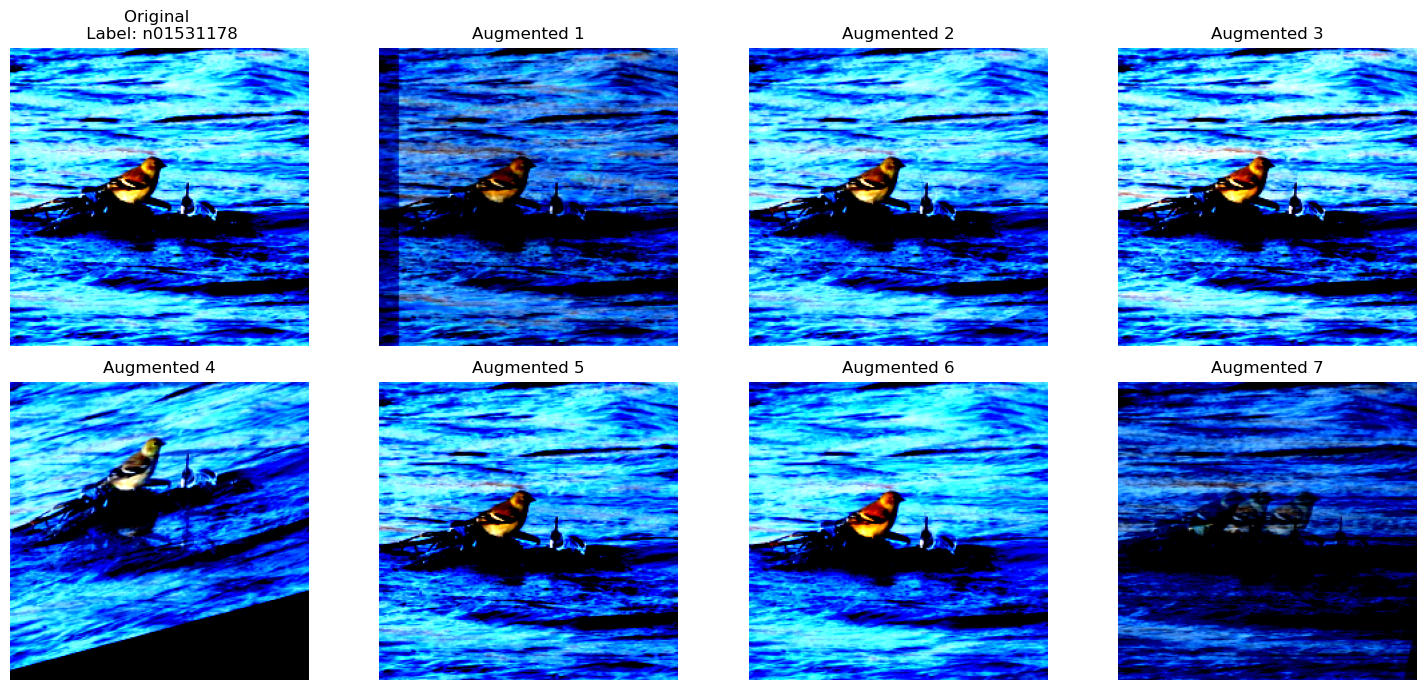

In [30]:
# Example of usage of dataset with Augmix augmentations

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 7

# Define the directory containing the dataset
root_dir = 'imagenet-a/'

# Instantiate the dataset
dataset_A_Augmix = AugMixDataset(root_dir,
                                 num_augmentations=num_augmentations,
                                 transform=transform)

# Show one example
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
i = 140  # Index of sample to show
sample, label = dataset_A_Augmix[i]

# Display each image in the sample
for j, img in enumerate(sample):
    ax = axes[j // 4, j % 4]
    # Normalize the pixel values to be within [0, 1]
    img = img.permute(1, 2, 0)
    img = img.numpy()  # Convert PyTorch tensor to NumPy array
    ax.imshow(img)
    ax.axis('off')
    # Caption the images
    if j == 0:
        ax.set_title(f'Original \n Label: {label}')
    else:
        ax.set_title(f'Augmented {j}')

plt.tight_layout()
plt.show()

### Adaptive batch normalization

An AdaptiveBatchNorm2d class is defined to implement adaptive batch normalization (BN) for handling distribution shifts during inference. The following cell also includes utility functions to recursively replace standard batch normalization layers with adaptive ones in a given model. The approach, inspired by Schneider et al., combines statistics from training and test data to improve model robustness at test time.

Adaptive batch normalization (BN) adjusts the estimated mean and variance of the activations in each BN layer by mixing the statistics computed from the training data with those estimated from the test data. This helps in handling distribution shifts effectively. The mixing is controlled by a prior strength parameter N, which balances the influence of training and test statistics and is set to 16 by default.

For a parameter $ \nu \in \{\mu, \sigma^2\} $ (mean $\mu$ and variance $\sigma^2$):

$$\nu = \frac{N}{N+1} \nu_{\text{train}} + \frac{1}{N+1} \nu_{\text{test}}$$

In [23]:
class AdaptiveBatchNorm2d(nn.BatchNorm2d):
    """
    Adaptive Batch Normalization layer for 2D inputs.
    This class extends `torch.nn.BatchNorm2d` to combine running statistics
    from training with statistics computed from test data during inference.

    Parameters
    num_features (int): Number of features or channels in the input.
    prior_strength (int, optional): Weighting factor for combining training and test statistics, by default 16.
    eps (float, optional): A small value added to variance to avoid division by zero, by default 1e-5.
    momentum (float, optional): Momentum for updating running statistics, by default 0.1.
    affine (bool, optional): Whether to include learnable affine parameters (scale and shift), by default True.
    """

    def __init__(self, num_features, prior_strength=16, eps=1e-5, momentum=0.1, affine=True):
        super(AdaptiveBatchNorm2d, self).__init__(num_features, eps=eps, momentum=momentum, affine=affine)
        self.prior_strength = prior_strength

    def forward(self, input):
        """
        Parameters
        input (torch.Tensor): Input tensor of shape (N, C, H, W) where N is the batch size,
        C is the number of channels, H is the height, and W is the width.

        Returns
        torch.Tensor: Normalized tensor with the same shape as input.
        """
        device = input.device

        if not self.training:
            running_mean = self.running_mean.to(device)
            running_var = self.running_var.to(device)

            test_mean = input.mean([0, 2, 3])
            test_var = input.var([0, 2, 3], unbiased=False)

            train_weight = self.prior_strength / (self.prior_strength + 1)
            test_weight = 1 - train_weight

            mixed_mean = (train_weight * running_mean + test_weight * test_mean).to(device).detach()
            mixed_var = (train_weight * running_var + test_weight * test_var).to(device).detach()

            return nn.functional.batch_norm(
                input, mixed_mean, mixed_var, self.weight.to(device), self.bias.to(device), False, self.momentum, self.eps
            )
        else:
            return super(AdaptiveBatchNorm2d, self).forward(input)


def replace_bn_with_adaptive_bn(module):
    """
    Replace all `torch.nn.BatchNorm2d` layers in a module with `AdaptiveBatchNorm2d`.

    Parameters
    module (torch.nn.Module): The module in which to replace batch normalization layers.
    Returns
    torch.nn.Module: The module with `nn.BatchNorm2d` layers replaced by `AdaptiveBatchNorm2d`.
    """
    module_output = module
    if isinstance(module, nn.BatchNorm2d):
        module_output = AdaptiveBatchNorm2d(module.num_features,
                                            eps=module.eps, momentum=module.momentum,
                                            affine=module.affine)
        if module.affine:
            module_output.weight.data = module.weight.data.clone().detach()
            module_output.bias.data = module.bias.data.clone().detach()
    for name, child in module.named_children():
        module_output.add_module(name, replace_bn_with_adaptive_bn(child))
    return module_output

### Problem with Adaptive Batch Normalization

In the context of Batch Normalization (BN), the running mean and running variance are essential statistical parameters used to normalize input features during training and inference. These parameters are updated dynamically based on the input data to ensure that the model's performance is not affected by changes in the input distribution.

However, we encountered a critical issue where the running mean and variance of the BN layers remained unchanged throughout the adaptation process. This indicates that the BN layers were not being updated correctly, which can lead to poor model performance and inaccurate predictions.

Despite observing reasonable test mean and variance values that accurately reflected the input batch statistics, the running mean and variance remained stuck at zeros and ones, respectively. This suggests that the BN layers were not properly adapting to the input data, which is a critical component of the model's training process.

Due to time constraints, after numerous attempts, we were unable to resolve this issue. For this reason, we were not able to perform experiments and further analyze the model's behavior when using this technique.

### Test-time adaptation (main function)

The *test_time_adapt_MEMO* function is designed to run and evaluate the test-time adaptation of a convolutional neural network (CNN) using the MEMO approach.

It includes a checkpointing mechanism which is useful since running an experiment on large datasets may take much time and the kernel may die during the execution.

For each correctly loaded test sample (a batch of *num_augmentations* + 1 images) the function proceeds to move the image tensor to the GPU, if possible, and sets the model to evaluation mode to obtain the initial predictions. It then optionally applies a mask to the model's outputs to extract only specific classes (e.g., for ImageNet-A) and selects the top-k most confident augmentations if enabled. Then:

 - it computes the predicted class for the original test image (without considering any augmentation) and increments the counter *n_correct_bf* if the prediction is correct (this is done for evaluation purposes);
 - it calculates the predicted class from the average distribution before adaptation and updates the related counter *n_correct_augm_bf*.
 - The function then performs the specified number of adaptation steps, during which it computes the gradients of the entropy of the marginal output distribution and updates the model's parameters accordingly. After adaptation, it re-evaluates the model to get the new predictions and updates the counter *n_correct_af* for correct predictions after adaptation.
 
The model and optimizer states are then reset to their initial configurations to ensure that the adaptation steps do not affect subsequent samples.

In [24]:
def test_time_adapt_MEMO(mymodel,
                         optimizer,
                         dataset,
                         device,
                         checkpoint_name_to_save,
                         apply_mask=False,
                         mask=None,
                         reduced_labels_list=ids_200,
                         n_optim_steps=1,
                         confidence_selection=False,
                         k=10,
                         verbose=False,
                         start_from_checkpoint=False,
                         checkpoint_name_to_use=None,
                         checkpoint_interval=1,
                         checkpoint_dir="checkpoints"):
    """
    Test-time adaptation using MEMO approach.

    Parameters:
        - mymodel (torch.nn.Module): Pre-trained CNN model (e.g., ResNet50).
        - optimizer (torch.optim.Optimizer): Optimizer object.
        - dataset (torch.utils.data.Dataset): Dataset containing the images to be processed.
        - device (torch.device): Device to perform computations on (GPU if available, otherwise CPU).
        - checkpoint_name_to_save (str): File name to save the checkpoints.
        - apply_mask (bool, optional): Whether to extract only specific outputs from model predictions (for fewer classes, e.g., with ImageNet-A).
        - mask (list of bool, optional): List of dimension same as number of output classes of the model, with True for positions to extract.
        - reduced_labels_list (list, optional): List containing the labels of 200 ImageNet-A classes (needed to get label from index).
        - n_optim_steps (int, optional): Number of optimization/adaptation steps to perform for each test sample.
        - confidence_selection (bool, optional): Whether to keep predictions for the most confident augmentations.
        - k (int, optional): Number of most confident augmentations to consider if `confidence_selection` is True.
        - verbose (bool, optional): Whether to print information for each image.
        - start_from_checkpoint (bool, optional): Whether to start from a checkpoint.
        - checkpoint_name_to_use (str, optional): File name of the checkpoint to use if `start_from_checkpoint` is True.
        - checkpoint_interval (int, optional): Number of iterations after which to save a checkpoint.
        - checkpoint_dir (str, optional): Directory where checkpoints are saved.


    Returns:
        - n_correct_bf (int): Correct predictions from single test image (no augmentations considered) BEFORE adaptation
        - n_correct_augm_bf (int): Correct predictions (averaged over test image + augmentations) BEFORE adaptation
        - n_correct_af (int): Correct predictions (averaged over test image + augmentations) AFTER adaptation
        - n_valid_samples (int): Counter for valid samples in the dataset (some images may not be opened correctly)
    """
#############################################################################################################

    print('Running...')

    # Create directory 'checkpoints'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Initialize counters for evaluation
    n_correct_bf = 0
    n_correct_augm_bf = 0
    n_correct_af = 0
    n_valid_samples = 0

    # Retrieve counters from checkpoint (if used)
    if start_from_checkpoint:
        print(f'Starting from checkpoint {checkpoint_name_to_use}.')
        ckpt_path = os.path.join(checkpoint_dir, checkpoint_name_to_use)
        if os.path.exists(ckpt_path):
            # Load previous results
            idx_last_processed_image, n_valid_samples, n_correct_bf, n_correct_augm_bf, n_correct_af = load_test_checkpoint(ckpt_path)
        else:
            raise FileNotFoundError(f"Checkpoint file '{ckpt_path}' does not exist.")

    # Index of first image to analyze
    start_idx = idx_last_processed_image + 1 if start_from_checkpoint else 0

    # Iterate over the test dataset
    for i in range(start_idx, len(dataset)):

        test_sample, correct_label = dataset[i]  # test_sample is a tensor of shape [N+1, num_classes]

        # For Imagenet-v2 dataset, convert labels (strings of integers 0-999) to integers
        if not apply_mask:
            correct_label = int(correct_label)

        if test_sample is not None:  # Check if image is opened correctly

            n_valid_samples += 1  # the current sample is valid, increment counter

            # Move sample to GPU if possible
            test_sample = test_sample.to(device)

            start_time = time.time() 
            vprint(f'Image {i+1} / {len(dataset)}. Correct label: {correct_label}', verbose)

            vprint('First forward pass...', verbose)

            # Set model to evaluation mode to get the outputs
            mymodel.eval()
            # Pass a test sample to the model (a batch of 1 test image and N augmentations)
            outputs_batch = mymodel(test_sample)  # raw outputs: tensor of dim [N+1, num_classes]
            # Keep just the output values of the 200 classes of Imagenet-A if this is the case
            if apply_mask:
                outputs_batch = outputs_batch[:, mask]

            # Compute predicted class index of just the original test image (withouth considering the augmentations)
            outputs_test_img = outputs_batch[0]  # dim [num_classes] , raw outputs (no softmax) of the original test image
            pred_class_idx = torch.argmax(outputs_test_img).item()  # predicted class index
            # Get label from index
            predicted_label = reduced_labels_list[pred_class_idx] if apply_mask else pred_class_idx
            vprint(f'Predicted class label of test image: {predicted_label}', verbose)
            # Increment counter if the prediction is correct
            if predicted_label == correct_label:
                n_correct_bf += 1

            # Keep outputs of top k most confident augmentations
            if confidence_selection:
                outputs_batch = select_top_k(outputs_batch, k)

            # Predicted class from average distribution BEFORE ADAPTATION
            avg_outputs = outputs_batch.mean(dim=0)  # dim [num_classes]
            pred_class_idx = torch.argmax(avg_outputs).item()
            # Get label from index
            predicted_label = reduced_labels_list[pred_class_idx] if apply_mask else pred_class_idx
            vprint(f'Predicted label from avg distr. BEFORE ADAPTATION: {predicted_label}', verbose)
            # Increment counter if the prediction is correct
            if predicted_label == correct_label:
                n_correct_augm_bf += 1
            # Compute entropy of marginal output distribution BEFORE ADAPTATION (just for printing purposes)
            ent = marginal_entropy(outputs_batch)
            vprint(f'Entropy of marginal output distribution BEFORE ADAPTATION: {ent.item()}', verbose)

            # PERFORM n_optim_steps ADAPTATION STEPS
            for optim_step in range(n_optim_steps):
                vprint(f'Performing optimization step n. {optim_step+1} out of {n_optim_steps} ...', verbose)
                outputs_batch = mymodel(test_sample)  # raw outputs: tensor of dim [N+1, num_classes]
                # Extract 200 classes of Imagenet-A if needed
                if apply_mask:
                    outputs_batch = outputs_batch[:, mask]
                # Keep outputs of top k most confident augmentations
                if confidence_selection:
                    outputs_batch = select_top_k(outputs_batch, k)
                ent = marginal_entropy(outputs_batch)  # Compute entropy
                ent.backward()  # Compute gradients
                optimizer.step()  # Optimization step
                optimizer.zero_grad()  # Clear gradients

            vprint('Second forward pass...', verbose)
            outputs_batch = mymodel(test_sample)  # Get new outputs of dim [N+1, num_classes]
            # Keep just the output values of the 200 classes of Imagenet-A if needed
            if apply_mask:
                outputs_batch = outputs_batch[:, mask]
            # Keep outputs of top k most confident augmentations
            if confidence_selection:
                outputs_batch = select_top_k(outputs_batch, k)

            # Predicted class from average distribution AFTER ADAPTATION
            avg_outputs = outputs_batch.mean(dim=0)  # dim [num_classes]
            pred_class_idx = torch.argmax(avg_outputs).item()
            # Get label from index
            predicted_label = reduced_labels_list[pred_class_idx] if apply_mask else pred_class_idx
            vprint(f'Predicted label from avg distr. AFTER ADAPTATION: {predicted_label}', verbose)
            # Increment counter if the prediction is correct
            if predicted_label == correct_label:
                n_correct_af += 1
            # Compute entropy of marginal output distribution (of 200 Imagenet-A classes) AFTER ADAPTATION
            ent = marginal_entropy(outputs_batch)
            vprint(f'Entropy of marginal output distribution AFTER ADAPTATION: {ent.item()}', verbose)

            # Reset the weights and the optimizer to their initial configuration
            mymodel.load_state_dict(torch.load('initial_weights.pth'))
            optimizer.load_state_dict(torch.load('optim_initial_state.pth'))

            end_time = time.time()
            elapsed_time = end_time - start_time
            vprint(f'Elapsed time: {round(elapsed_time, 2)} seconds.', verbose)

        # Print current accuracy info periodically
        if (i+1) % 100 == 0:
            print('='*90)
            print(f'Test samples opened correctly: {n_valid_samples} out of {i+1}')
            print(f'Accuracy on single test images BA: {(n_correct_bf/n_valid_samples) * 100:.3f}%')
            print(f'Accuracy on test images + augmentations BA: {(n_correct_augm_bf/n_valid_samples) * 100:.3f}%')
            print(f'Accuracy after adaptation: {(n_correct_af/n_valid_samples) * 100:.3f}%')
            print('='*90)

        # Save a checkpoint periodically
        if (i+1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name_to_save)
            save_test_checkpoint(checkpoint_path, i, n_valid_samples,
                                 n_correct_bf, n_correct_augm_bf, n_correct_af)

    return n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples

## EXPERIMENTS

In this section, we present the results obtained from our experiments evaluating the model. We used ResNet50 as the base model in all experiments, with the default weights from PyTorch, as they provided the best performance. We did not use the ResNet50 weights trained on DeepAugment and AugMix (as cited in [1]) because they resulted in significantly lower performance. 

The optimizer employed was Adam, with a learning rate of 0.0001 in all cases. This configuration was selected through trial and error and proved to be the most effective. Due to the high computational cost, with a single experiment on the full ImageNet-A or ImageNet-v2 datasets taking between 1 to 2 hours, we did not explore many different configurations of base models, optimizers, or hyperparameters.

The experiments are divided into two sections: one for ImageNet-A and one for ImageNet-v2. At the end of each section, we provide a summary table of the results along with comments and analysis on the outcomes of the experiments.

## EXPERIMENTS ON IMAGENET-A

### Experiment 0 (baseline) 

- **Dataset**: Imagenet-A
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: "possible_augmentations" list
- **Number of augmentations for each image**: 9
- **Confidence selection strategy**: not used
- **Adaptive batch normalization**: not used
- **Seed**: 86 (for reproducibility)

In [ ]:
## EXPERIMENT 0 ##

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 9

# Define the directory containing the dataset
root_dir = 'imagenet-a/'

# Instantiate the dataset
dataset_A = S3ImageFolder(root_dir,
                          augmentations=possible_augmentations,
                          num_augmentations=num_augmentations,
                          transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.0001)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_A,
    device=device,
    apply_mask=True,
    mask=mask,
    checkpoint_name_to_save='experiment_0_1.pth',
    start_from_checkpoint=True,
    checkpoint_name_to_use='experiment_0_1.pth'
)

In [12]:
# Retrieve results of experiment 0
results(experiment_name='experiment_0', dataset='Imagenet-A')

Index of last processed image:  7499
Results of experiment on Imagenet-A:
Top 1 accuracy using single test image: 14.240%
Top 1 accuracy using test image + augmentations: 12.800%
Top 1 accuracy with test-time adaptation: 14.813%


### Experiment 1 (more augmentations)

- **Dataset**: Imagenet-A
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: augmentations defined in the list *possible_augmentations*
- **Number of augmentations for each image**: 15
- **Confidence selection strategy**: not used
- **Adaptive batch normalization**: not used
- **Seed**: 86 (for reproducibility)

In [ ]:
## EXPERIMENT 1 ##

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 15

# Define the directory containing the dataset
root_dir = 'imagenet-a/'

# Instantiate the dataset
dataset_A = S3ImageFolder(root_dir,
                          augmentations=possible_augmentations,
                          num_augmentations=num_augmentations,
                          transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.0001)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_A,
    device=device,
    apply_mask=True,
    mask=mask,
    checkpoint_name_to_save='experiment_1.pth'
)

In [13]:
# Retrieve results of experiment 1
results(experiment_name='experiment_1', dataset='Imagenet-A')

Index of last processed image:  7499
Results of experiment on Imagenet-A:
Top 1 accuracy using single test image: 14.240%
Top 1 accuracy using test image + augmentations: 13.093%
Top 1 accuracy with test-time adaptation: 14.893%


### Experiment 2 (Augmix)

In the following experiment we will use (random horizontal flip) + (Augmix) for the augmentations.

- **Dataset**: Imagenet-A
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: **Augmix**
- **Number of augmentations for each image**: 15
- **Confidence selection strategy**: not used
- **Adaptive batch normalization**: not used
- **Seed**: 86 (for reproducibility)

In [ ]:
## EXPERIMENT 2 ##

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 15

# Define the directory containing the dataset
root_dir = 'imagenet-a/'

# Instantiate the dataset (Augmix version)
dataset_A_Augmix = AugMixDataset(root_dir,
                                 num_augmentations=num_augmentations,
                                 transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.0001)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_A_Augmix,
    device=device,
    apply_mask=True,
    mask=mask,
    checkpoint_name_to_save='experiment_2.pth'
)

In [14]:
# Retrieve results of experiment 2
results(experiment_name='experiment_2', dataset='Imagenet-A')

Index of last processed image:  7499
Results of experiment on Imagenet-A:
Top 1 accuracy using single test image: 14.267%
Top 1 accuracy using test image + augmentations: 10.547%
Top 1 accuracy with test-time adaptation: 11.907%


### Experiment 4 (baseline + adaptive batch norm) (WE WERE UNABLE TO RUN THIS)

Introduce **adaptive batch normalization** to the baseline.

- **Dataset**: Imagenet-A
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: possible_augmentations
- **Number of augmentations for each image**: 9
- **Confidence selection strategy**: not used
- **Adaptive batch normalization**: **YES**
- **Seed**: 86 (for reproducibility)

In [ ]:
## EXPERIMENT 4 (unable to run) ##

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 9

# Define the directory containing the dataset
root_dir = 'imagenet-a/'

# Instantiate the dataset
dataset_A = S3ImageFolder(root_dir,
                          augmentations=possible_augmentations,
                          num_augmentations=num_augmentations,
                          transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)
mymodel = replace_bn_with_adaptive_bn(mymodel)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.0001)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_A,
    device=device,
    apply_mask=True,
    mask=mask,
    checkpoint_name_to_save='experiment_4.pth'
)

### Experiment 5 (baseline + confidence selection)

Introduce **confidence selection strategy** to the baseline.

- **Dataset**: Imagenet-A
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: possible_augmentations
- **Number of augmentations for each image**: 9
- **Confidence selection strategy**: **YES** (k=5)
- **Adaptive batch normalization**: not used
- **Seed**: 86 (for reproducibility)

In [ ]:
## EXPERIMENT 5 ##

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 9

# Define the directory containing the dataset
root_dir = 'imagenet-a/'

# Instantiate the dataset
dataset_A = S3ImageFolder(root_dir,
                          augmentations=possible_augmentations,
                          num_augmentations=num_augmentations,
                          transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.00001)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_A,
    device=device,
    apply_mask=True,
    mask=mask,
    confidence_selection=True,
    k=5,
    checkpoint_name_to_save='experiment_5.pth'
)

In [17]:
# Retrieve results of experiment 5
results(experiment_name='experiment_5', dataset='Imagenet-A')

Index of last processed image:  7499
Results of experiment on Imagenet-A:
Top 1 accuracy using single test image: 14.240%
Top 1 accuracy using test image + augmentations: 14.827%
Top 1 accuracy with test-time adaptation: 15.320%


### Experiment 6 (baseline with more augmentations + confidence selection)

- **Dataset**: Imagenet-A
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: possible_augmentations
- **Number of augmentations for each image**: 15
- **Confidence selection strategy**: **YES** (k=5)
- **Adaptive batch normalization**: not used
- **Seed**: 86 (for reproducibility)

In [ ]:
# EXPERIMENT 6

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 15

# Define the directory containing the dataset
root_dir = 'imagenet-a/'

# Instantiate the dataset
dataset_A = S3ImageFolder(root_dir,
                          augmentations=possible_augmentations,
                          num_augmentations=num_augmentations,
                          transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.00001)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_A,
    device=device,
    apply_mask=True,
    mask=mask,
    confidence_selection=True,
    k=5,
    checkpoint_name_to_save='experiment_6.pth'
)

In [23]:
# Retrieve results of experiment 6
results(experiment_name='experiment_6', dataset='Imagenet-A')

Index of last processed image:  7499
Results of experiment on Imagenet-A:
Top 1 accuracy using single test image: 14.240%
Top 1 accuracy using test image + augmentations: 16.213%
Top 1 accuracy with test-time adaptation: 16.667%


### Summary results for Imagenet-A

The following table presents the results of various experiments conducted to test the efficacy of the MEMO approach on the ImageNet-A dataset using a ResNet50 model with different configurations. Each experiment aims to evaluate how certain modifications and strategies impact the model's accuracy before and after adaptation.

| Exp n° | Base model | Weights         | Optimizer       | n_optim_steps | Augmentations (type, number) | CS        | BN | Acc. 1   | Acc. 2   | Acc. 3   |
|--------|------------|-----------------|-----------------|---------------|------------------------------|-----------|----|----------|----------|----------|
| 0      | ResNet50   | Pytorch default | Adam, lr=0.0001 | 1             | *possible_augmentations*, 9  | No        | No | 14.240 % | 12.800 % | 14.813 % |
| 1      | ResNet50   | Pytorch default | Adam, lr=0.0001 | 1             | *possible_augmentations*, 15 | No        | No | 14.240 % | 13.093 % | 14.893 % |
| 2      | ResNet50   | Pytorch default | Adam, lr=0.0001 | 1             | Augmix, 15                   | No        | No | 14.267 % | 10.547 % | 11.907 % |
| 5      | ResNet50   | Pytorch default | Adam, lr=0.0001 | 1             | *possible_augmentations*, 9  | Yes (k=5) | No | 14.240 % | 14.827 % | 15.320 % |
| 6      | ResNet50   | Pytorch default | Adam, lr=0.0001 | 1             | *possible_augmentations*, 15 | Yes (k=5) | No | 14.240 % | 16.213 % | **16.667 %** |

**Legend:**
 - CS: confidence selection strategy. k is the number of most confident predictions retained.
 - BN: Adaptive batch normalization statistics with prior strength.
 - Acc. 1: accuracy on single test images BEFORE adaptation.
 - Acc. 2: accuracy on images + augmentations BEFORE adaptation.
 - Acc. 3: accuracy AFTER adaptation.

The accuracy of the base model on Imagenet-A, when considering single test images is 14.240%. The baseline approach shows a slight improvement in accuracy after adaptation (Acc. 3), even if the performance with augmentations (Acc. 2) is slightly lower than that on the single test images, indicating some noise introduced by the augmentations. This aspect will be consistent in almost all of the next experiments. Increasing the number of augmentations to 15 leads to a minor improvement in accuracy after adaptation compared to the baseline.

Using Augmix for augmentations results in a significant drop both in the accuracy averaged over test image and augmentations and in accuracy after adaptation. This indicates that the augmentations provided by Augmix may add too much noise, due to the severity parameter set to its maximum value of 10. However, the choice of this parameter was empirical and was suggested by the fact that using smaller values of the severity parameter resulted in augmentations that were almost identical to the original images. 

Introducing confidence selection improves the accuracy after adaptation compared to the baseline. This suggests that filtering out low-confidence predictions helps in focusing on more reliable information, enhancing the adaptation process. Lastly, combining more augmentations with confidence selection yields the highest accuracy after adaptation. This configuration seems to strike the best balance between augmentation diversity and confident prediction filtering, leading to the most robust performance.

## EXPERIMENTS ON IMAGENET-V2

### Modification of dataset class for Imagenet-v2 dataset

Unlike with the ImageNet-A dataset, for the ImageNet-v2 dataset, all images are resized to 224 pixels while maintaining their aspect ratio before applying any augmentations. After resizing, the standard transformations required by the chosen model are applied. We opted for this resizing strategy because ResNet50 exhibited significantly better performance on ImageNet-v2 even with the resized images. This approach also helped reduce the execution time of each experiment.

In [34]:
class S3ImageFolderv2(Dataset):
    """
        Same as dataset class for Imagenet-A, but with resizing to 224 
        (while mantaining aspect ratio) to ALL images prior to the creation 
        of augmentations.
    """

    def __init__(self, root_dir, augmentations, num_augmentations=5, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"  # Ireland
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.root_dir = root_dir
        self.augmentations = augmentations
        self.num_augmentations = num_augmentations
        self.transform = transform

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root_dir)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root_dir,
                ContinuationToken=response["NextContinuationToken"]
            )
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)

            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):

        label, key = self.instances[idx]

        # Download image as bytes array
        img_bytes = BytesIO()
        self.s3_client.download_fileobj(Bucket=self.s3_bucket, Key=key, Fileobj=img_bytes)

        # Check if image is opened correctly
        try:
            img = Image.open(img_bytes).convert('RGB')
        except UnidentifiedImageError:
            # If it cannot be opened
            return None, None  # This image will be skipped later

        img = resize_keep_ar(img)  # Resize to 224, keeping aspect ratio
        img = T.functional.to_tensor(img)  # Turn to tensor

        # Create num_augmentations augmentations
        augmented_images = [img]
        random_augm = random.sample(population=self.augmentations, k=self.num_augmentations)
        for augmentation in random_augm:
            augmented_image = augmentation(img)
            augmented_images.append(augmented_image)

        # Apply transformations
        if self.transform:
            augmented_images = [self.transform(img) for img in augmented_images]

        # Create a batch including the original image and its augmentations.
        # Eeach test sample is a batch containing 1 + num_augmentations images, so
        # it is a tensor with dimensions [num_augmentations + 1, 3, H, W].
        test_sample = torch.stack(augmented_images, dim=0)

        return test_sample, label

In [45]:
class Augmix_v2_dataset(Dataset):
    """
        Same as Augmix class for Imagenet-A, but with resizing to 224 
        (while mantaining aspect ratio) to ALL images prior to the creation 
        of Augmix augmentations.
    """

    def __init__(self, root_dir, num_augmentations=5, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"  # Ireland
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.root_dir = root_dir
        self.num_augmentations = num_augmentations
        self.transform = transform

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root_dir)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root_dir,
                ContinuationToken=response["NextContinuationToken"]
            )
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)

            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):

        label, key = self.instances[idx]

        # Download image as bytes array
        img_bytes = BytesIO()
        self.s3_client.download_fileobj(Bucket=self.s3_bucket, Key=key, Fileobj=img_bytes)

        # Check if image is opened correctly
        try:
            img = Image.open(img_bytes).convert('RGB')
        except UnidentifiedImageError:
            # If it cannot be opened
            return None, None  # This image will be skipped later

        img = resize_keep_ar(img)  # Resize to 224, keeping aspect ratio

        # Create num_augmentations augmentations
        augmented_images = [img]
        for _ in range(self.num_augmentations):
            aug_transform = AugMix(severity=10)
            flip = T.RandomHorizontalFlip(p=0.4)
            img = flip(img)  # apply a random horizontal flip before augmenting it
            augmented_img = aug_transform(img)  # apply Augmix augmentation
            augmented_images.append(augmented_img)

        # Apply transformations
        if self.transform:
            augmented_images = [self.transform(img) for img in augmented_images]

        # Create a batch including the original image and its augmentations.
        # Eeach test sample is a batch containing 1 + num_augmentations images, so
        # it is a tensor with dimensions [num_augmentations + 1, 3, H, W].
        test_sample = torch.stack(augmented_images, dim=0)

        return test_sample, label

### Experiment 0 (baseline) 

- **Dataset**: Imagenet-v2
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: augmentations defined in the list *possible_augmentations*
- **Number of augmentations for each image**: 9
- **Confidence selection strategy**: not used
- **Adaptive batch normalization**: not used
- **Seed**: 86 (for reproducibility)

In [ ]:
## EXPERIMENT 0 (v2) ##

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 9

# Define the directory containing the dataset
root_dir = 'imagenetv2-matched-frequency-format-val/'

# Instantiate the dataset
dataset_v2 = S3ImageFolderv2(root_dir,
                             augmentations=possible_augmentations,
                             num_augmentations=num_augmentations,
                             transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.0001)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_v2,
    device=device,
    checkpoint_name_to_save='experiment_0_v2.pth'
)

In [37]:
# Retrieve results of experiment 0_v2
results('experiment_0_v2', dataset='Imagenet-v2')

Index of last processed image:  9999
Results of experiment on Imagenet-v2:
Top 1 accuracy using single test image: 66.980%
Top 1 accuracy using test image + augmentations: 62.620%
Top 1 accuracy with test-time adaptation: 61.340%


### Experiment 1 (more augmentations)

- **Dataset**: Imagenet-v2
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: augmentations defined in the list *possible_augmentations*
- **Number of augmentations for each image**: 15
- **Confidence selection strategy**: not used
- **Adaptive batch normalization**: not used
- **Seed**: 86 (for reproducibility)

In [ ]:
## EXPERIMENT 1 (v2) ##

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 15

# Define the directory containing the dataset
root_dir = 'imagenetv2-matched-frequency-format-val/'

# Instantiate the dataset
dataset_v2 = S3ImageFolderv2(root_dir,
                             augmentations=possible_augmentations,
                             num_augmentations=num_augmentations,
                             transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.0001)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_v2,
    device=device,
    checkpoint_name_to_save='experiment_1_v2.pth'
)

### Experiment 2 (Augmix)

In the following experiment we will use (random horizontal flip) + (Augmix) for the (31) augmentations.
Confidence selection is also used, with k = 10.

- **Dataset**: Imagenet-v2
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: **Augmix**
- **Number of augmentations for each image**: 25
- **Confidence selection strategy**: YES (k=10)
- **Adaptive batch normalization**: not used
- **Seed**: 86 (for reproducibility)

In [ ]:
## EXPERIMENT 2 (v2) ##

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 25

# Define the directory containing the dataset
root_dir = 'imagenetv2-matched-frequency-format-val/'

# Instantiate the dataset
dataset_v2_augmix = Augmix_v2_dataset(root_dir,
                               num_augmentations=num_augmentations,
                               transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.005)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_v2_augmix,
    device=device,
    confidence_selection=True,
    k=10,
    checkpoint_name_to_save='experiment_2_v2.pth'
)

In [51]:
results('experiment_2_v2', 'Imaganet-v2')

Index of last processed image:  9999
Results of experiment on Imaganet-v2:
Top 1 accuracy using single test image: 66.920%
Top 1 accuracy using test image + augmentations: 65.180%
Top 1 accuracy with test-time adaptation: 63.310%


### Experiment 3 (baseline + batch norm) (WE WERE UNABLE TO RUN THIS)

Introduce **adaptive batch normalization** to the baseline.

- **Dataset**: Imagenet-v2
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: possible_augmentations
- **Number of augmentations for each image**: 9
- **Confidence selection strategy**: not used
- **Adaptive batch normalization**: **YES**
- **Seed**: 86 (for reproducibility)

### Experiment 4 (baseline + confidence selection)

Introduce **confidence selection strategy** to the baseline.

- **Dataset**: Imagenet-v2
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: possible_augmentations
- **Number of augmentations for each image**: 9
- **Confidence selection strategy**: **YES** (k=5)
- **Adaptive batch normalization**: not used
- **Seed**: 86 (for reproducibility)

In [ ]:
## EXPERIMENT 4 (v2) ##

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 9

# Define the directory containing the dataset
root_dir = 'imagenetv2-matched-frequency-format-val/'

# Instantiate the dataset
dataset_v2 = S3ImageFolderv2(root_dir,
                             augmentations=possible_augmentations,
                             num_augmentations=num_augmentations,
                             transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.0001)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_v2,
    device=device,
    confidence_selection=True,
    k=5,
    checkpoint_name_to_save='experiment_4_v2.pth'
)

In [61]:
results('experiment_4_v2', dataset='Imagenet-v2')

Index of last processed image:  9999
Results of experiment on Imagenet-v2:
Top 1 accuracy using single test image: 66.980%
Top 1 accuracy using test image + augmentations: 62.100%
Top 1 accuracy with test-time adaptation: 59.880%


### Experiment 6 (baseline with more augmentations + confidence selection)

- **Dataset**: Imagenet-v2
- **Base model**: ResNet50
- **Weights**: default
- **Optimizer**: Adam with lr=0.0001
- **Number of adaptation steps**: 1
- **Types of augmentations**: possible_augmentations
- **Number of augmentations for each image**: 15
- **Confidence selection strategy**: **YES** (k=5)
- **Adaptive batch normalization**: not used
- **Seed**: 86 (for reproducibility)

In [ ]:
## EXPERIMENT 6 (v2) ##

# Set seed
random.seed(86)

# Transformations required by the CNN pre-trained model that has been chosen
transform = ResNet50_Weights.DEFAULT.transforms(antialias=True)

# Number of augmentations to apply to each image
num_augmentations = 15

# Define the directory containing the dataset
root_dir = 'imagenetv2-matched-frequency-format-val/'

# Instantiate the dataset
dataset_v2 = S3ImageFolderv2(root_dir,
                             augmentations=possible_augmentations,
                             num_augmentations=num_augmentations,
                             transform=transform)

# Choose weights
my_weights = ResNet50_Weights.DEFAULT  # default weights

# Instantiate a pretrained model with chosen weights
mymodel = resnet50(weights=my_weights)

# Instantiate the optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.0001)

# Save the initial weights
torch.save(mymodel.state_dict(), 'initial_weights.pth')

# Save optimizer's initial configuration
torch.save(optimizer.state_dict(), 'optim_initial_state.pth')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.to(device)

# Perform test-time adaptation
n_correct_bf, n_correct_augm_bf, n_correct_af, n_valid_samples = test_time_adapt_MEMO(
    mymodel=mymodel,
    optimizer=optimizer,
    dataset=dataset_v2,
    device=device,
    checkpoint_name_to_save='experiment_6_v2.pth',
    confidence_selection=True,
    k=5
)

In [40]:
results('experiment_6_v2', 'Imagenet-v2')

Index of last processed image:  9999
Results of experiment on Imagenet-v2:
Top 1 accuracy using single test image: 66.980%
Top 1 accuracy using test image + augmentations: 61.220%
Top 1 accuracy with test-time adaptation: 58.860%


### Summary results for Imagenet-v2

The following table presents the results of various experiments conducted to test the efficacy of the MEMO approach on the Imagenet-v2 dataset using a ResNet50 model with different configurations. Each experiment is designed to assess how certain modifications and strategies affect the model's accuracy before and after adaptation.


| Exp n° | Base model | Weights         | Optimizer       | n_optim_steps | Augmentations (type, number) | CS        | BN | Acc. 1   | Acc. 2   | Acc. 3   |
|--------|------------|-----------------|-----------------|---------------|------------------------------|-----------|----|----------|----------|----------|
| 0      | ResNet50   | Pytorch default | Adam, lr=0.0001 | 1             | *possible_augmentations*, 15  | No        | No | 66.980 % | 62.680 % | 62.350 % |
| 1      | ResNet50   | Pytorch default | Adam, lr=0.0001 | 1             | *possible_augmentations*, 9  | No        | No | 66.980 % | 62.620 % | 61.340 % |
| 2      | ResNet50   | Pytorch default | Adam, lr=0.0001 | 1             | Augmix, 25                   | Yes (k=10)        | No | 66.920 % | 65.180 % | 63.310 % |
| 4      | ResNet50   | Pytorch default | Adam, lr=0.0001 | 1             | *possible_augmentations*, 9 | Yes (k=5) | No | 66.980 % | 62.100 % | 59.880 % |
| 6      | ResNet50   | Pytorch default | Adam, lr=0.0001 | 1             | *possible_augmentations*, 15 | Yes (k=5) | No | 66.980 % | 61.220 % | 58.860 % |


**Legend:**
 - CS: confidence selection strategy. k is the number of most confident predictions retained.
 - BN: Adapting batch normalization statistics with prior strength.
 - Acc. 1: accuracy on single test images BEFORE adaptation.
 - Acc. 2: accuracy on images + augmentations BEFORE adaptation.
 - Acc. 3: accuracy AFTER adaptation.


The experiments that have been run on Imagenet-v2 show that none of the strategies used on Imagenet-A are effective in this case. The baseline shows a drop in accuracy from single test images to augmented images. This may be due to the fact that the base model already achieves a much higher accuracy of 66.980 % on test images alone and therefore, using augmentations is more likely to produce worse results. The accuracy after adaptation remains stable (compared to Acc. 2) and this may be due to the quite small value of the learning rate of the optimizer. However, when trying to use higher values of the learning rate, the performance after adaptation decreased. Reducing the number of augmentations from 15 to 9 keeps the accuracy Acc. 2 almost identical but slightly lowers the overall performance after adaptation. 

Using Augmix augmentations combined with confidence selection improves accuracy on augmented images and after adaptation compared to previous cases (since possibly uncertain predictions are filtered out by the confidence selection strategy), but is still worse compared to the performance of the base model without test-time adaptation. 
Confidence selection with k=5 and 9 or 15 augmentations (chosen in the list *possible_augmentations*) results in a noticeable drop in accuracy after adaptation, unlike with Imagenet-A, where these configurations yielded the best performance. 

One possible explanation to this results is that the configurations and strategies that have been tested are likely to provide a (small) increase in the performance of the base model just in cases where the base accuracy is very low (as for Imagenet-A). However, further work is needed to corroborate this hypothesis, including trying several base models and repeating our experiments on different types of datasets.

## References

 - [1] Zhang, Marvin, Sergey Levine, and Chelsea Finn. "Memo: Test time robustness via adaptation and augmentation." Advances in neural information processing systems 35 (2022): 38629-38642.
 - [2] Shu, Manli, et al. "Test-time prompt tuning for zero-shot generalization in vision-language models." Advances in Neural Information Processing Systems 35 (2022): 14274-14289.
 - [3] Schneider, Steffen, et al. "Improving robustness against common corruptions by covariate shift adaptation." Advances in neural information processing systems 33 (2020): 11539-11551.